In [1]:
train_url = "https://huggingface.co/datasets/Tomate/Kaggle-Titanic/raw/main/train.csv" #@param {type:"string"}
predict_url = "https://huggingface.co/datasets/Tomate/Kaggle-Titanic/raw/main/test.csv" #@param {type:"string"}
y_column_name = "Survived" #@param {type:"string"}
seed = 1337

# **Libraries and Data Load**

Instalamos Nevergrad para realizar más adelante la optimización de hiperparámetros.

In [2]:
random_seed = 1337

In [3]:
# !pip install nevergrad

In [4]:
import pandas as pd
import warnings
import seaborn as sns
from matplotlib import pyplot as plt
import numpy as np
import os
import math
# import sklearn.compose
# from sklearn.model_selection import train_test_split
# import nevergrad as ng
# 
# from sklearn.metrics import f1_score
# from sklearn.metrics import accuracy_score
# from sklearn.neighbors import NearestCentroid
# from sklearn.model_selection import GridSearchCV
# from sklearn.linear_model import LogisticRegression
# from sklearn.svm import LinearSVC
# from sklearn import svm
# from sklearn.neighbors import KNeighborsClassifier
# from sklearn.naive_bayes import CategoricalNB
# from sklearn.naive_bayes import GaussianNB
# from sklearn.naive_bayes import MultinomialNB
# from sklearn.naive_bayes import BernoulliNB
# from sklearn.naive_bayes import ComplementNB
# from sklearn.tree import DecisionTreeClassifier
# from sklearn.tree import ExtraTreeClassifier
# from sklearn.preprocessing import PolynomialFeatures
# from sklearn.ensemble import VotingClassifier
# from sklearn.ensemble import BaggingClassifier
# from sklearn.ensemble import AdaBoostClassifier
# from sklearn.ensemble import GradientBoostingClassifier
# from sklearn.ensemble import StackingClassifier
# import tensorflow as tf
# import tensorflow.keras as K
# 
# 
# 
# from keras import backend as Ke

Se cargan los datos de entrenamiento y los necesarios para hacer la predicción desde un repositorio online. Los datos de entrenamiento se mezclan de forma aleatoria.

In [5]:
data_predict = pd.read_csv("https://huggingface.co/datasets/Tomate/Kaggle-Titanic/raw/main/test.csv", sep=",")

data_train = pd.read_csv("https://huggingface.co/datasets/Tomate/Kaggle-Titanic/raw/main/train.csv", sep=",")
data_train = data_train.sample(frac=1, random_state=random_seed).reset_index(drop=True)

data_train

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,644,1,3,"Foo, Mr. Choong",male,NaN,0,0,1601,56.4958,NaN,S
1,794,0,1,"Hoyt, Mr. William Fisher",male,NaN,0,0,PC 17600,30.6958,NaN,C
2,175,0,1,"Smith, Mr. James Clinch",male,56.0,0,0,17764,30.6958,A7,C
3,16,1,2,"Hewlett, Mrs. (Mary D Kingcome)",female,55.0,0,0,248706,16.0000,NaN,S
4,792,0,2,"Gaskell, Mr. Alfred",male,16.0,0,0,239865,26.0000,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,168,0,3,"Skoog, Mrs. William (Anna Bernhardina Karlsson)",female,45.0,1,4,347088,27.9000,NaN,S
887,233,0,2,"Sjostedt, Mr. Ernst Adolf",male,59.0,0,0,237442,13.5000,NaN,S
888,861,0,3,"Hansen, Mr. Claus Peter",male,41.0,2,0,350026,14.1083,NaN,S
889,190,0,3,"Turcin, Mr. Stjepan",male,36.0,0,0,349247,7.8958,NaN,S


**transfrom_Y** se encarga de transformar la columna de salida en dos columnas objetivo (una de victoria contraterrorista y otra de victoria terrorista).

**inverse_transform_Y** se encarga de hacer el proceso contrario del método anterior.

In [6]:
# onehot = sklearn.preprocessing.OneHotEncoder()
# def transform_Y (y):
#   result = []
#   for el in y:
#     result.append([el])
#   result = onehot.fit_transform(result).toarray()
#   return pd.DataFrame(result, columns=y.unique())

# def inverse_transform_Y (y, index=None):
#   aux = onehot.inverse_transform(y)
#   result = []
#   for el in aux:
#     result.append(el[0])
#   return pd.Series(result, index=index)

**f1_score_m** implementa la métrica de calidad f1 y hace uso de los métodos **recall_m** y **precision_m** para calcularla.

In [7]:
# def recall_m(y_true, y_pred):
#   true_positives = Ke.sum(Ke.round(Ke.clip(y_true * y_pred, 0, 1)))
#   possible_positives = Ke.sum(Ke.round(Ke.clip(y_true, 0, 1)))
#   recall = true_positives / (possible_positives + Ke.epsilon())
#   return recall

# def precision_m(y_true, y_pred):
#   true_positives = Ke.sum(Ke.round(Ke.clip(y_true * y_pred, 0, 1)))
#   predicted_positives = Ke.sum(Ke.round(Ke.clip(y_pred, 0, 1)))
#   precision = true_positives / (predicted_positives + Ke.epsilon())
#   return precision

# def f1_score_m (y_true, y_pred):
#   precision = precision_m(y_true, y_pred)
#   recall = recall_m(y_true, y_pred)
#   return 2*((precision*recall)/(precision+recall+Ke.epsilon()))

# **Initial Study**

## *Describe*

In [8]:
data_train.describe(include="all")

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
count,891.000000,891.000000,891.000000,891,891,714.000000,891.000000,891.000000,891,891.000000,204,889
unique,NaN,NaN,NaN,891,2,NaN,NaN,NaN,681,NaN,147,3
top,NaN,NaN,NaN,"Foo, Mr. Choong",male,NaN,NaN,NaN,1601,NaN,B96 B98,S
freq,NaN,NaN,NaN,1,577,NaN,NaN,NaN,7,NaN,4,644
mean,446.000000,0.383838,2.308642,NaN,NaN,29.699118,0.523008,0.381594,NaN,32.204208,NaN,NaN
std,257.353842,0.486592,0.836071,NaN,NaN,14.526497,1.102743,0.806057,NaN,49.693429,NaN,NaN
min,1.000000,0.000000,1.000000,NaN,NaN,0.420000,0.000000,0.000000,NaN,0.000000,NaN,NaN
25%,223.500000,0.000000,2.000000,NaN,NaN,20.125000,0.000000,0.000000,NaN,7.910400,NaN,NaN
50%,446.000000,0.000000,3.000000,NaN,NaN,28.000000,0.000000,0.000000,NaN,14.454200,NaN,NaN
75%,668.500000,1.000000,3.000000,NaN,NaN,38.000000,1.000000,0.000000,NaN,31.000000,NaN,NaN


## *Correlation Matrix*

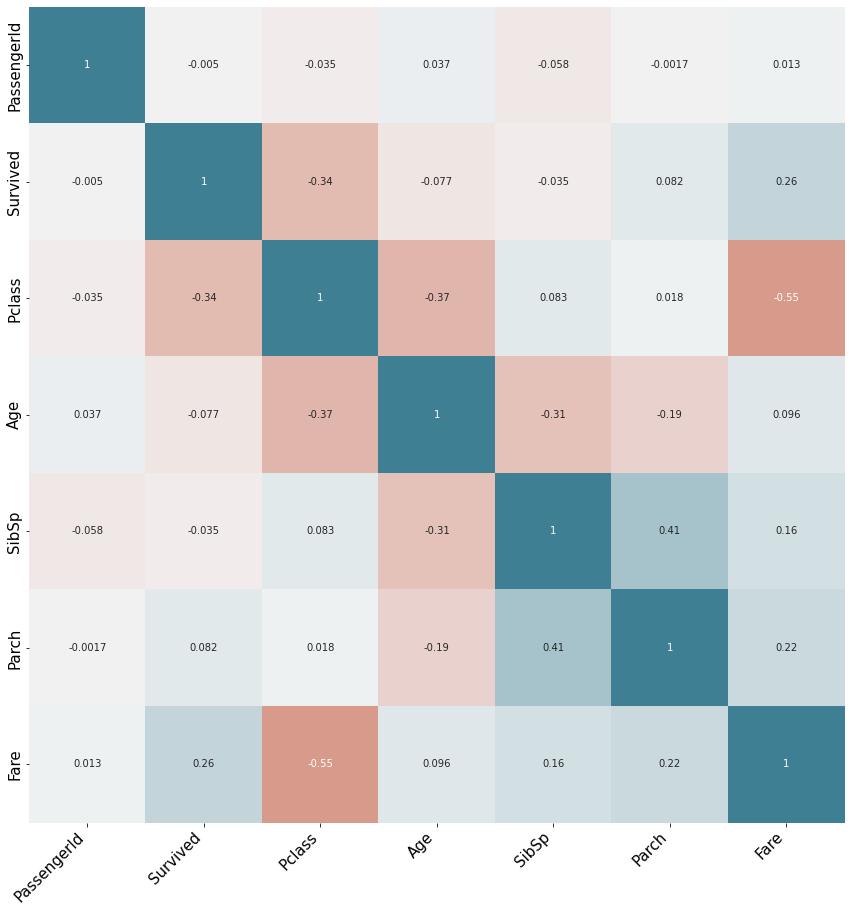

In [9]:
def drawCorrelationMatrix(X):
  correlationMatrix = X.corr(method='pearson')

  fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize = (15, 15))

  sns.heatmap(
      correlationMatrix,
      annot     = True,
      cbar      = False,
      annot_kws = {"size": 10},
      vmin      = -1,
      vmax      = 1,
      center    = 0,
      cmap      = sns.diverging_palette(20, 220, n=200),
      square    = True,
      ax        = ax
)
  ax.set_xticklabels(
      ax.get_xticklabels(),
      rotation = 45,
      horizontalalignment = 'right',
  )

  ax.tick_params(labelsize = 15)

drawCorrelationMatrix(data_train)

# **Preprocessing**


In [10]:
data_train

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,644,1,3,"Foo, Mr. Choong",male,NaN,0,0,1601,56.4958,NaN,S
1,794,0,1,"Hoyt, Mr. William Fisher",male,NaN,0,0,PC 17600,30.6958,NaN,C
2,175,0,1,"Smith, Mr. James Clinch",male,56.0,0,0,17764,30.6958,A7,C
3,16,1,2,"Hewlett, Mrs. (Mary D Kingcome)",female,55.0,0,0,248706,16.0000,NaN,S
4,792,0,2,"Gaskell, Mr. Alfred",male,16.0,0,0,239865,26.0000,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,168,0,3,"Skoog, Mrs. William (Anna Bernhardina Karlsson)",female,45.0,1,4,347088,27.9000,NaN,S
887,233,0,2,"Sjostedt, Mr. Ernst Adolf",male,59.0,0,0,237442,13.5000,NaN,S
888,861,0,3,"Hansen, Mr. Claus Peter",male,41.0,2,0,350026,14.1083,NaN,S
889,190,0,3,"Turcin, Mr. Stjepan",male,36.0,0,0,349247,7.8958,NaN,S


In [11]:
columns = data_train.columns
columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

## *Methods*

In [12]:
def get_categories(X, column_name, keep_null=False):
  categories = X[column].unique()
  if keep_null==False:
    categories = categories[~pd.isnull(categories)]
  return categories

In [13]:
def one_hot_encoder(X, column_name, categories, others=False):
  for element in categories:
    X[column_name + '_' + str(element)] = 0.0

  if others != False:
    other_name = column_name + '_' + 'other'
    X[other_name] = 0.0

  for i in range(len(X[column_name])):
    if X[column_name][i] in categories:
      X[column_name + '_' + str(X[column_name][i])][i] = 1.0
    elif others != False:
      X[other_name][i] = 1.0
  X.pop(column_name)

In [14]:
def replace_null(X, column_name, replace_with=0, replace_average=True):
  if replace_average:
    value = 0.0
  else:
    value = 0.0
  for i in range(len(X[column_name])):
    if math.isnan(X[column][i]):
      print("DETECTADO")
      X[column_name][i] = value
  return value

## *Survived*

In [15]:
column = "Survived"

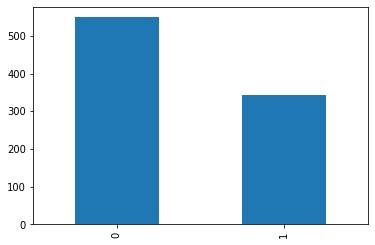

In [16]:
#@markdown # Barplot
data_train[column].value_counts().plot(kind="bar")

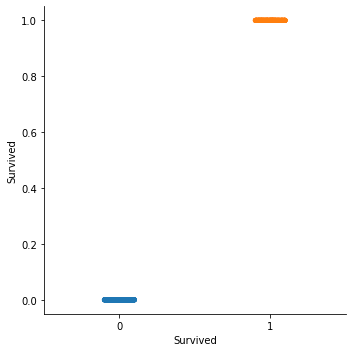

In [17]:
#@markdown # Catplot
sns.catplot(x=column, y=column, data=data_train)

## *Pclass*

In [18]:
column = "Pclass"

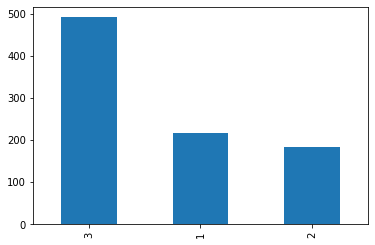

In [19]:
#@markdown # Barplot
data_train[column].value_counts().plot(kind="bar")

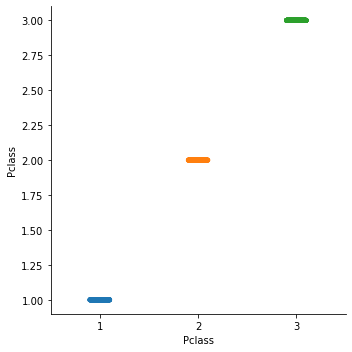

In [20]:
#@markdown # Catplot
sns.catplot(x=column, y=column, data=data_train)

In [21]:
categories = get_categories(data_train, column, keep_null=True)
categories

array([3, 1, 2])

In [22]:
one_hot_encoder(data_train, column, categories)
one_hot_encoder(data_predict, column, categories)
data_train

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


,PassengerId,Survived,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Pclass_3,Pclass_1,Pclass_2
0,644,1,"Foo, Mr. Choong",male,NaN,0,0,1601,56.4958,NaN,S,1.0,0.0,0.0
1,794,0,"Hoyt, Mr. William Fisher",male,NaN,0,0,PC 17600,30.6958,NaN,C,0.0,1.0,0.0
2,175,0,"Smith, Mr. James Clinch",male,56.0,0,0,17764,30.6958,A7,C,0.0,1.0,0.0
3,16,1,"Hewlett, Mrs. (Mary D Kingcome)",female,55.0,0,0,248706,16.0000,NaN,S,0.0,0.0,1.0
4,792,0,"Gaskell, Mr. Alfred",male,16.0,0,0,239865,26.0000,NaN,S,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,168,0,"Skoog, Mrs. William (Anna Bernhardina Karlsson)",female,45.0,1,4,347088,27.9000,NaN,S,1.0,0.0,0.0
887,233,0,"Sjostedt, Mr. Ernst Adolf",male,59.0,0,0,237442,13.5000,NaN,S,0.0,0.0,1.0
888,861,0,"Hansen, Mr. Claus Peter",male,41.0,2,0,350026,14.1083,NaN,S,1.0,0.0,0.0
889,190,0,"Turcin, Mr. Stjepan",male,36.0,0,0,349247,7.8958,NaN,S,1.0,0.0,0.0


## *Sex*

In [23]:
column = "Sex"

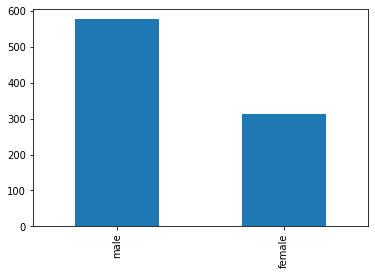

In [24]:
#@markdown # Barplot
data_train[column].value_counts().plot(kind="bar")

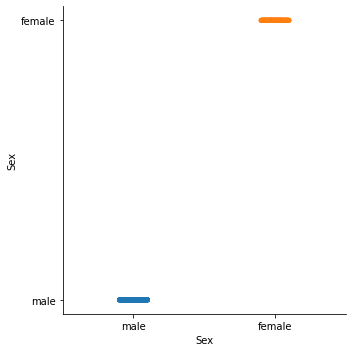

In [25]:
#@markdown # Catplot
sns.catplot(x=column, y=column, data=data_train)

In [26]:
categories = get_categories(data_train, column, keep_null=True)
categories

array(['male', 'female'], dtype=object)

In [27]:
one_hot_encoder(data_train, column, categories)
one_hot_encoder(data_predict, column, categories)
data_train

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


,PassengerId,Survived,Name,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Pclass_3,Pclass_1,Pclass_2,Sex_male,Sex_female
0,644,1,"Foo, Mr. Choong",NaN,0,0,1601,56.4958,NaN,S,1.0,0.0,0.0,1.0,0.0
1,794,0,"Hoyt, Mr. William Fisher",NaN,0,0,PC 17600,30.6958,NaN,C,0.0,1.0,0.0,1.0,0.0
2,175,0,"Smith, Mr. James Clinch",56.0,0,0,17764,30.6958,A7,C,0.0,1.0,0.0,1.0,0.0
3,16,1,"Hewlett, Mrs. (Mary D Kingcome)",55.0,0,0,248706,16.0000,NaN,S,0.0,0.0,1.0,0.0,1.0
4,792,0,"Gaskell, Mr. Alfred",16.0,0,0,239865,26.0000,NaN,S,0.0,0.0,1.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,168,0,"Skoog, Mrs. William (Anna Bernhardina Karlsson)",45.0,1,4,347088,27.9000,NaN,S,1.0,0.0,0.0,0.0,1.0
887,233,0,"Sjostedt, Mr. Ernst Adolf",59.0,0,0,237442,13.5000,NaN,S,0.0,0.0,1.0,1.0,0.0
888,861,0,"Hansen, Mr. Claus Peter",41.0,2,0,350026,14.1083,NaN,S,1.0,0.0,0.0,1.0,0.0
889,190,0,"Turcin, Mr. Stjepan",36.0,0,0,349247,7.8958,NaN,S,1.0,0.0,0.0,1.0,0.0


## *SibSp*

In [28]:
column = "SibSp"

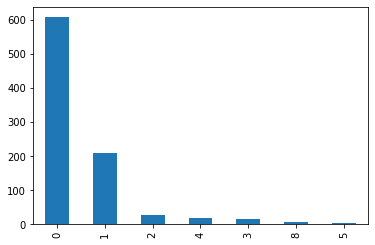

In [29]:
#@markdown # Barplot
data_train[column].value_counts().plot(kind="bar")

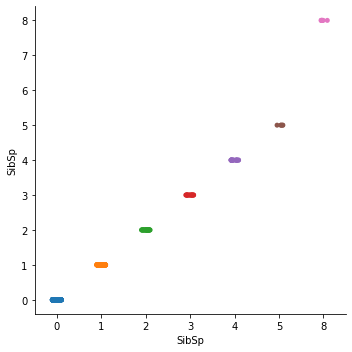

In [30]:
#@markdown # Catplot
sns.catplot(x=column, y=column, data=data_train)

In [31]:
categories = get_categories(data_train, column, keep_null=True)
categories

array([0, 1, 3, 2, 8, 5, 4])

In [32]:
one_hot_encoder(data_train, column, categories)
one_hot_encoder(data_predict, column, categories)
data_train

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


,PassengerId,Survived,Name,Age,Parch,Ticket,Fare,Cabin,Embarked,Pclass_3,...,Pclass_2,Sex_male,Sex_female,SibSp_0,SibSp_1,SibSp_3,SibSp_2,SibSp_8,SibSp_5,SibSp_4
0,644,1,"Foo, Mr. Choong",NaN,0,1601,56.4958,NaN,S,1.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,794,0,"Hoyt, Mr. William Fisher",NaN,0,PC 17600,30.6958,NaN,C,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,175,0,"Smith, Mr. James Clinch",56.0,0,17764,30.6958,A7,C,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,16,1,"Hewlett, Mrs. (Mary D Kingcome)",55.0,0,248706,16.0000,NaN,S,0.0,...,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,792,0,"Gaskell, Mr. Alfred",16.0,0,239865,26.0000,NaN,S,0.0,...,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,168,0,"Skoog, Mrs. William (Anna Bernhardina Karlsson)",45.0,4,347088,27.9000,NaN,S,1.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
887,233,0,"Sjostedt, Mr. Ernst Adolf",59.0,0,237442,13.5000,NaN,S,0.0,...,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
888,861,0,"Hansen, Mr. Claus Peter",41.0,0,350026,14.1083,NaN,S,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
889,190,0,"Turcin, Mr. Stjepan",36.0,0,349247,7.8958,NaN,S,1.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


## *Parch*

In [33]:
column = "Parch"

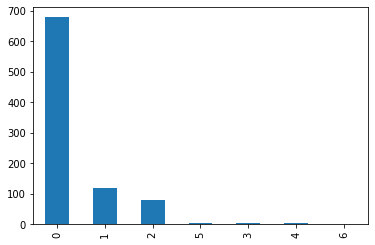

In [34]:
#@markdown # Barplot
data_train[column].value_counts().plot(kind="bar")

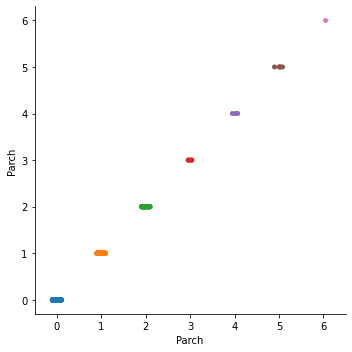

In [35]:
#@markdown # Catplot
sns.catplot(x=column, y=column, data=data_train)

In [36]:
categories = get_categories(data_train, column, keep_null=True)
categories

array([0, 6, 2, 1, 5, 3, 4])

In [37]:
one_hot_encoder(data_train, column, categories)
one_hot_encoder(data_predict, column, categories)
data_train

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


,PassengerId,Survived,Name,Age,Ticket,Fare,Cabin,Embarked,Pclass_3,Pclass_1,...,SibSp_8,SibSp_5,SibSp_4,Parch_0,Parch_6,Parch_2,Parch_1,Parch_5,Parch_3,Parch_4
0,644,1,"Foo, Mr. Choong",NaN,1601,56.4958,NaN,S,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,794,0,"Hoyt, Mr. William Fisher",NaN,PC 17600,30.6958,NaN,C,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,175,0,"Smith, Mr. James Clinch",56.0,17764,30.6958,A7,C,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,16,1,"Hewlett, Mrs. (Mary D Kingcome)",55.0,248706,16.0000,NaN,S,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,792,0,"Gaskell, Mr. Alfred",16.0,239865,26.0000,NaN,S,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,168,0,"Skoog, Mrs. William (Anna Bernhardina Karlsson)",45.0,347088,27.9000,NaN,S,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
887,233,0,"Sjostedt, Mr. Ernst Adolf",59.0,237442,13.5000,NaN,S,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
888,861,0,"Hansen, Mr. Claus Peter",41.0,350026,14.1083,NaN,S,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
889,190,0,"Turcin, Mr. Stjepan",36.0,349247,7.8958,NaN,S,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


## *Cabin*

In [38]:
column = "Cabin"

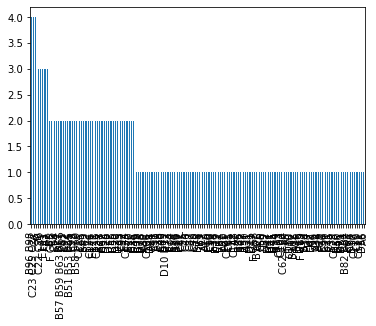

In [39]:
#@markdown # Barplot
data_train[column].value_counts().plot(kind="bar")

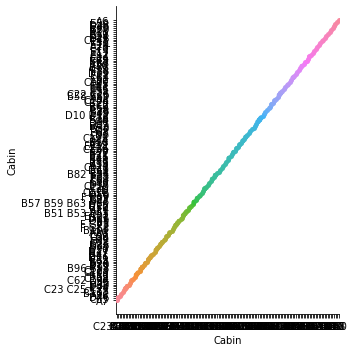

In [40]:
#@markdown # Catplot
sns.catplot(x=column, y=column, data=data_train)

In [41]:
categories = get_categories(data_train, column, keep_null=True)
categories

array([nan, 'A7', 'C65', 'D46', 'A36', 'B102', 'C118', 'C23 C25 C27',
       'E44', 'D30', 'A5', 'D35', 'C62 C64', 'C104', 'B35', 'E8', 'C103',
       'C123', 'B96 B98', 'B19', 'D20', 'B94', 'E33', 'C52', 'D26', 'B41',
       'B37', 'D17', 'B20', 'D47', 'D36', 'E25', 'C82', 'D9', 'C78',
       'C50', 'E67', 'A26', 'B101', 'F G63', 'F2', 'F G73', 'B5', 'D49',
       'D11', 'E101', 'C93', 'B51 B53 B55', 'A31', 'F4', 'B50', 'D15',
       'B57 B59 B63 B66', 'D45', 'C83', 'F E69', 'D50', 'D56', 'C111',
       'D', 'C30', 'C110', 'D37', 'C86', 'C68', 'E63', 'F33', 'B82 B84',
       'C54', 'D21', 'E46', 'C128', 'A14', 'B39', 'B86', 'B49', 'C45',
       'B71', 'B22', 'C90', 'C126', 'E36', 'E121', 'A19', 'B18', 'A34',
       'C125', 'C32', 'D6', 'E68', 'D7', 'B30', 'B42', 'C7', 'D33', 'G6',
       'B28', 'E38', 'D10 D12', 'E49', 'B38', 'E58', 'B69', 'C2', 'B79',
       'C124', 'C106', 'A32', 'B58 B60', 'C22 C26', 'E34', 'C95', 'C46',
       'C47', 'C85', 'C101', 'A20', 'C92', 'B4', 'E77', 'D19'

In [42]:
one_hot_encoder(data_train, column, categories)
one_hot_encoder(data_predict, column, categories)
data_train

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


,PassengerId,Survived,Name,Age,Ticket,Fare,Embarked,Pclass_3,Pclass_1,Pclass_2,...,Cabin_D28,Cabin_A24,Cabin_C91,Cabin_A10,Cabin_B73,Cabin_B80,Cabin_E40,Cabin_D48,Cabin_E50,Cabin_A6
0,644,1,"Foo, Mr. Choong",NaN,1601,56.4958,S,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,794,0,"Hoyt, Mr. William Fisher",NaN,PC 17600,30.6958,C,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,175,0,"Smith, Mr. James Clinch",56.0,17764,30.6958,C,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,16,1,"Hewlett, Mrs. (Mary D Kingcome)",55.0,248706,16.0000,S,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,792,0,"Gaskell, Mr. Alfred",16.0,239865,26.0000,S,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,168,0,"Skoog, Mrs. William (Anna Bernhardina Karlsson)",45.0,347088,27.9000,S,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
887,233,0,"Sjostedt, Mr. Ernst Adolf",59.0,237442,13.5000,S,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
888,861,0,"Hansen, Mr. Claus Peter",41.0,350026,14.1083,S,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
889,190,0,"Turcin, Mr. Stjepan",36.0,349247,7.8958,S,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## *Embarked*

In [43]:
column = "Embarked"

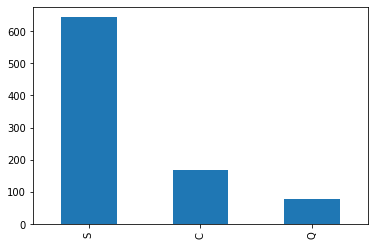

In [44]:
#@markdown # Barplot
data_train[column].value_counts().plot(kind="bar")

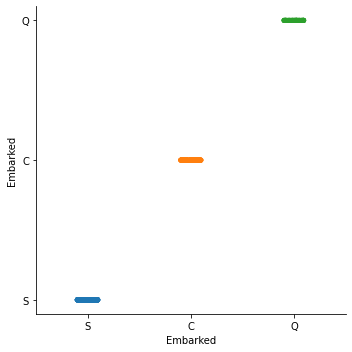

In [45]:
#@markdown # Catplot
sns.catplot(x=column, y=column, data=data_train)

In [46]:
categories = get_categories(data_train, column, keep_null=True)
categories

array(['S', 'C', 'Q', nan], dtype=object)

In [47]:
one_hot_encoder(data_train, column, categories)
one_hot_encoder(data_predict, column, categories)
data_train

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  This is separate from the ipykernel package so we can avoid doing imports until


,PassengerId,Survived,Name,Age,Ticket,Fare,Pclass_3,Pclass_1,Pclass_2,Sex_male,...,Cabin_B73,Cabin_B80,Cabin_E40,Cabin_D48,Cabin_E50,Cabin_A6,Embarked_S,Embarked_C,Embarked_Q,Embarked_nan
0,644,1,"Foo, Mr. Choong",NaN,1601,56.4958,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,794,0,"Hoyt, Mr. William Fisher",NaN,PC 17600,30.6958,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,175,0,"Smith, Mr. James Clinch",56.0,17764,30.6958,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,16,1,"Hewlett, Mrs. (Mary D Kingcome)",55.0,248706,16.0000,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,792,0,"Gaskell, Mr. Alfred",16.0,239865,26.0000,0.0,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,168,0,"Skoog, Mrs. William (Anna Bernhardina Karlsson)",45.0,347088,27.9000,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
887,233,0,"Sjostedt, Mr. Ernst Adolf",59.0,237442,13.5000,0.0,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
888,861,0,"Hansen, Mr. Claus Peter",41.0,350026,14.1083,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
889,190,0,"Turcin, Mr. Stjepan",36.0,349247,7.8958,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


## *Age*

In [48]:
column = "Age"

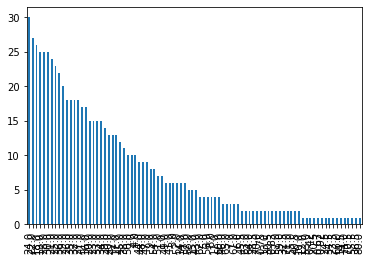

In [49]:
#@markdown # Barplot
data_train[column].value_counts().plot(kind="bar")

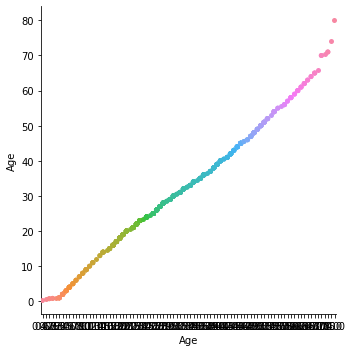

In [50]:
#@markdown # Catplot
sns.catplot(x=column, y=column, data=data_train)

In [51]:
replace_null(data_train,column, replace_with=0.0, replace_average=False)
replace_null(data_predict,column, replace_with=0.0, replace_average=False)
data_train

DETECTADO
DETECTADO
DETECTADO
DETECTADO
DETECTADO
DETECTADO
DETECTADO
DETECTADO
DETECTADO
DETECTADO
DETECTADO
DETECTADO
DETECTADO
DETECTADO
DETECTADO
DETECTADO
DETECTADO
DETECTADO
DETECTADO
DETECTADO
DETECTADO
DETECTADO
DETECTADO
DETECTADO
DETECTADO
DETECTADO
DETECTADO
DETECTADO
DETECTADO
DETECTADO
DETECTADO
DETECTADO
DETECTADO
DETECTADO
DETECTADO
DETECTADO
DETECTADO
DETECTADO
DETECTADO
DETECTADO
DETECTADO
DETECTADO
DETECTADO
DETECTADO
DETECTADO
DETECTADO
DETECTADO
DETECTADO
DETECTADO
DETECTADO
DETECTADO
DETECTADO
DETECTADO
DETECTADO
DETECTADO
DETECTADO
DETECTADO
DETECTADO
DETECTADO
DETECTADO
DETECTADO
DETECTADO
DETECTADO
DETECTADO
DETECTADO
DETECTADO
DETECTADO
DETECTADO
DETECTADO
DETECTADO
DETECTADO
DETECTADO
DETECTADO
DETECTADO
DETECTADO
DETECTADO
DETECTADO
DETECTADO
DETECTADO
DETECTADO
DETECTADO
DETECTADO
DETECTADO
DETECTADO
DETECTADO
DETECTADO
DETECTADO
DETECTADO
DETECTADO
DETECTADO
DETECTADO
DETECTADO
DETECTADO
DETECTADO
DETECTADO
DETECTADO
DETECTADO
DETECTADO
DETECTADO
DETECTADO


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


DETECTADO
DETECTADO
DETECTADO
DETECTADO
DETECTADO
DETECTADO
DETECTADO
DETECTADO
DETECTADO
DETECTADO
DETECTADO
DETECTADO
DETECTADO
DETECTADO
DETECTADO
DETECTADO
DETECTADO
DETECTADO
DETECTADO
DETECTADO
DETECTADO
DETECTADO
DETECTADO
DETECTADO
DETECTADO
DETECTADO
DETECTADO
DETECTADO
DETECTADO
DETECTADO
DETECTADO
DETECTADO
DETECTADO
DETECTADO
DETECTADO
DETECTADO
DETECTADO
DETECTADO
DETECTADO
DETECTADO
DETECTADO
DETECTADO
DETECTADO
DETECTADO
DETECTADO
DETECTADO
DETECTADO
DETECTADO
DETECTADO
DETECTADO
DETECTADO
DETECTADO
DETECTADO
DETECTADO
DETECTADO
DETECTADO
DETECTADO
DETECTADO
DETECTADO
DETECTADO
DETECTADO
DETECTADO
DETECTADO
DETECTADO
DETECTADO
DETECTADO
DETECTADO
DETECTADO
DETECTADO
DETECTADO
DETECTADO
DETECTADO
DETECTADO
DETECTADO
DETECTADO
DETECTADO
DETECTADO
DETECTADO
DETECTADO
DETECTADO
DETECTADO
DETECTADO
DETECTADO
DETECTADO
DETECTADO
DETECTADO
DETECTADO
DETECTADO
DETECTADO
DETECTADO
DETECTADO
DETECTADO
DETECTADO
DETECTADO


,PassengerId,Survived,Name,Age,Ticket,Fare,Pclass_3,Pclass_1,Pclass_2,Sex_male,...,Cabin_B73,Cabin_B80,Cabin_E40,Cabin_D48,Cabin_E50,Cabin_A6,Embarked_S,Embarked_C,Embarked_Q,Embarked_nan
0,644,1,"Foo, Mr. Choong",0.0,1601,56.4958,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,794,0,"Hoyt, Mr. William Fisher",0.0,PC 17600,30.6958,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,175,0,"Smith, Mr. James Clinch",56.0,17764,30.6958,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,16,1,"Hewlett, Mrs. (Mary D Kingcome)",55.0,248706,16.0000,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,792,0,"Gaskell, Mr. Alfred",16.0,239865,26.0000,0.0,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,168,0,"Skoog, Mrs. William (Anna Bernhardina Karlsson)",45.0,347088,27.9000,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
887,233,0,"Sjostedt, Mr. Ernst Adolf",59.0,237442,13.5000,0.0,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
888,861,0,"Hansen, Mr. Claus Peter",41.0,350026,14.1083,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
889,190,0,"Turcin, Mr. Stjepan",36.0,349247,7.8958,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


## ELIMINAR COLUMNAS MOLESTAS

In [52]:
data_train.drop(columns='Name', inplace=True)
data_train.drop(columns='Ticket', inplace=True)
data_train.drop(columns='Fare', inplace=True) #nulos en el predict

data_predict.drop(columns='Name', inplace=True)
data_predict.drop(columns='Ticket', inplace=True)
data_predict.drop(columns='Fare', inplace=True)

## *RESULTS*

In [53]:
y_train = data_train['Survived']
X_train = data_train.copy()
X_train.drop(columns='Survived', inplace=True)
X_train.drop(columns='PassengerId', inplace=True)
data_train

,PassengerId,Survived,Age,Pclass_3,Pclass_1,Pclass_2,Sex_male,Sex_female,SibSp_0,SibSp_1,...,Cabin_B73,Cabin_B80,Cabin_E40,Cabin_D48,Cabin_E50,Cabin_A6,Embarked_S,Embarked_C,Embarked_Q,Embarked_nan
0,644,1,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,794,0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,175,0,56.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,16,1,55.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,792,0,16.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,168,0,45.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
887,233,0,59.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
888,861,0,41.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
889,190,0,36.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [54]:
X_predict = data_predict.copy()
X_predict.drop(columns='PassengerId', inplace=True)
data_predict

,PassengerId,Age,Pclass_3,Pclass_1,Pclass_2,Sex_male,Sex_female,SibSp_0,SibSp_1,SibSp_3,...,Cabin_B73,Cabin_B80,Cabin_E40,Cabin_D48,Cabin_E50,Cabin_A6,Embarked_S,Embarked_C,Embarked_Q,Embarked_nan
0,892,34.5,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,893,47.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,894,62.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,895,27.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,896,22.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
413,1305,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
414,1306,39.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
415,1307,38.5,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
416,1308,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


# **Save Predictions**

El método necesario para guardar las predicciones con un nombre característico en formato .csv

In [55]:
def guardar(score, prediccion, nombreModelo, ruta='/content', params=[]):
  try:
    os.mkdir(ruta)
  except:
    pass

  nombre = ruta + '/'+ str(score) + ' - '+nombreModelo
  for param in params:
    nombre += ' ' +param[0]+'='+str(param[1])

  nombre+='.csv'
  prediccion.to_csv(nombre, index=False)

# **Models**

## **Regresión Logística**

### ***Regresión Logística***

#### *Optimización*

Optimización de hiperparámetros por fuerza bruta.


In [ ]:
warnings.filterwarnings("ignore")

best_score = -1
best_params = (0, 0, 0, 0)
for max_iter in range(1, 2, 1):
  for penalty in ['l1', 'l2', 'elasticnet']:
    for solver in ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']:
      for l1_ratio in np.arange(0.0, 1.0, 0.1):
        try:
          regresionLogistica = LogisticRegression(max_iter=max_iter, penalty=penalty, solver=solver, l1_ratio=l1_ratio, n_jobs=-1)
          regresionLogistica.fit(X_train, y_train)
          y_pred = regresionLogistica.predict(X_val)
          scoreRegresionLogistica = f1_score(y_val, y_pred, average='weighted')
          if (scoreRegresionLogistica>best_score):
            best_params = (max_iter, penalty, solver,l1_ratio)
            best_score = scoreRegresionLogistica
            print("   NEW BEST=", bestScore, "PARAMS:", best_params)
        except:
          pass
print("BESTSCORE=", best_score, "PARAMS", best_params)

warnings.filterwarnings("default")

BESTSCORE= 0.7403260894980361 PARAMS (1, 'l2', 'liblinear', 0.0)


#### *Individual*

Entrenamiento con unos parámetros concretos

In [ ]:
max_iter = 100
penalty = 'l2' # ['l1', 'l2', 'elasticnet']:
solver = 'newton-cg' #, 'lbfgs', 'liblinear', 'sag', 'saga']:
l1_ratio = 1 #in np.arange(0.0, 1.0, 0.1):

regresionLogistica = LogisticRegression(max_iter=max_iter, penalty=penalty, solver=solver, l1_ratio=l1_ratio, n_jobs=-1)
regresionLogistica.fit(X_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1479: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  "(penalty={})".format(self.penalty)


0.7493516940642351

In [ ]:
y_pred = regresionLogistica.predict(X_val)
scoreRegresionLogistica = (f1_score(y_val, y_pred, average='weighted'), accuracy_score(y_val, y_pred))
scoreRegresionLogistica

In [ ]:
resultRegresionLogistica = pd.DataFrame({'id': data_test['id'], 'round_winner': regresionLogistica.predict(X_predict)})
resultRegresionLogistica

,id,round_winner
0,6548,CT
1,79093,T
2,103345,T
3,17113,CT
4,108774,T
...,...,...
48959,122127,T
48960,93115,T
48961,71219,T
48962,74073,CT


In [ ]:
guardar(score=scoreRegresionLogistica, prediccion=resultRegresionLogistica, nombreModelo="RegresionLogistica", ruta='/content/predicciones', 
        params=[])

### ***Regresión Polinómica***

#### *Optimización*

In [ ]:
best_score = -1
best_params = (0, 0, 0, 0)
for degree in range(1, 2, 1):
  poly = PolynomialFeatures(degree)
  poly.fit(X_train)
  X_train_poly = poly.transform(X_train)
  X_val_poly = poly.transform(X_val)
  for max_iter in range(100, 10001, 100):
    for penalty in ['l1', 'l2', 'elasticnet']:
      for solver in ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']:
        for l1_ratio in np.arange(0.0, 1.0, 0.1):
          try:
            regresionPolinomica = LogisticRegression(max_iter=max_iter, penalty=penalty, solver=solver, l1_ratio=l1_ratio, n_jobs=-1)
            regresionPolinomica.fit(X_train_poly, y_train)
            y_pred = regresionPolinomica.predict(X_val_poly)
            scoreRegresionPolinomica = f1_score(y_val, y_pred, average='weighted')
            if (scoreRegresionPolinomica>best_score):
              best_params = (max_iter, penalty, solver,l1_ratio)
              best_score = scoreRegresionPolinomica
              print("   NEW BEST=", bestScore, "PARAMS:", best_params)
          except:
            pass
print("BESTSCORE=", best_score, "PARAMS", best_params)

BESTSCORE= -1 PARAMS (0, 0, 0, 0)


#### *Individual*

In [ ]:
degree = 2
max_iter = 100
penalty = 'l2' #, 'l1', 'elasticnet']:
solver = 'newton-cg' #, 'lbfgs', 'liblinear', 'sag', 'saga']:
l1_ratio = 1 #in np.arange(0.0, 1.0, 0.1):

poly = PolynomialFeatures(degree)
poly.fit(X_train)
X_train_poly = poly.transform(X_train)

regresionPolinomica = LogisticRegression(max_iter=max_iter, penalty=penalty, solver=solver, l1_ratio=l1_ratio, n_jobs=-1)
regresionPolinomica.fit(X_train_poly, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1479: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  "(penalty={})".format(self.penalty)


In [ ]:
X_val_poly = poly.transform(X_val)
y_pred = regresionPolinomica.predict(X_val_poly)
scoreRegresionPolinomica = (f1_score(y_val, y_pred, average='weighted'), accuracy_score(y_val, y_pred))
scoreRegresionPolinomica

In [ ]:
regresionPolinomica = LogisticRegression(max_iter=max_iter, penalty=penalty, solver=solver, l1_ratio=l1_ratio, n_jobs=-1)
            regresionPolinomica.fit(X_poly, y_train)

resultRegresionPolinomica = pd.DataFrame({'id': data_test['id'], 'round_winner': regresionPolinomica.predict(X_predict)})
resultRegresionPolinomica

In [ ]:
guardar(score=scoreRegresionPolinomica, prediccion=resultRegresionPolinomica, nombreModelo="regresionPolinomica", ruta='/content/predicciones', 
        params=[])

## **Support Vector Machines**

In [ ]:
svc = svm.SVC(kernel='linear', probability=True)
svc.fit(X_train, y_train)

In [ ]:
y_pred = svc.predict(X_val)
scoreSupportVectorMachines = (f1_score(y_val, y_pred, average='weighted'), accuracy_score(y_val, y_pred))

In [ ]:
resultVectorMachines = pd.DataFrame({'id': data_test['id'], 'round_winner': svc.predict(X_predict)})
resultVectorMachines

In [ ]:
guardar(score=scoreSupportVectorMachines, prediccion=resultVectorMachines, nombreModelo="vectorMachines", ruta='/content/predicciones', 
        params=[])

## **KNN Classifier**

#### *Optimización*

In [ ]:
bestScore, bestParam = -1, (1, '')
for n_neighbors in range (1,101,1):
  for weights in ['uniform', 'distance']:
    knn = KNeighborsClassifier(n_neighbors=n_neighbors, weights=weights, n_jobs=-1)
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_val)
    scoreknn = f1_score(y_val, y_pred, average='weighted')
    if(scoreknn > bestScore):
      bestScore = scoreknn
      bestParam = (n_neighbors, weights)
      print("   NEW BEST=",bestScore, "n_neighbors=",n_neighbors, "weights=", weights)
print("BESTSCORE=",bestScore, "n_neighbors", bestParam([0]), "weights=", bestParam([1]))

#### *Individual*

In [ ]:
n_neighbors = 10
weights = 'distance' #uniform

knn = KNeighborsClassifier(n_neighbors=n_neighbors, weights=weights, n_jobs=-1)
knn.fit(X_train, y_train)

KNeighborsClassifier(n_jobs=-1, n_neighbors=10, weights='distance')

In [ ]:
y_pred = knn.predict(X_val)
scoreKNN= (f1_score(y_val, y_pred, average='weighted'), accuracy_score(y_val, y_pred))
scoreKNN

(0.8221164637607394, 0.822093128800944)

In [ ]:
resultKNN = pd.DataFrame({'id': data_test['id'], 'round_winner': knn.predict(X_predict)})
resultKNN

,id,round_winner
0,6548,CT
1,79093,CT
2,103345,T
3,17113,T
4,108774,T
...,...,...
48959,122127,T
48960,93115,CT
48961,71219,CT
48962,74073,CT


In [ ]:
guardar(score=scoreKNN, prediccion=resultKNN, nombreModelo="KNN", ruta='/content/predicciones', 
        params=[('n_neighbors',n_neighbors), ('weights',weights)])

## **Nearest Centroid**

#### *Optimizador*

In [ ]:
bestScore, bestParam = -1, -1
for shrink_threshold in range (1,101,1):
  nearestCentroid = NearestCentroid(shrink_threshold=shrink_threshold)
  nearestCentroid.fit(X_train, y_train)
  y_pred = nearestCentroid.predict(X_val)
  scoreNearestCentroid = f1_score(y_val, y_pred, average='weighted')
  if(scoreNearestCentroid>bestScore):
    bestScore = scoreNearestCentroid
    bestParam = shrink_threshold
    print("   NEW BEST=",bestScore, "shrink_threshold",bestParam)
print("BESTSCORE=",bestScore, "shrink_threshold",bestParam)

   NEW BEST= 0.6058432970092901 shrink_threshold 1
   NEW BEST= 0.7195346081648306 shrink_threshold 30
   NEW BEST= 0.7196420791257796 shrink_threshold 34
   NEW BEST= 0.7197750371121122 shrink_threshold 37
   NEW BEST= 0.7202791790591149 shrink_threshold 38
   NEW BEST= 0.7204992961894254 shrink_threshold 39
   NEW BEST= 0.720734547236868 shrink_threshold 40
BESTSCORE= 0.720734547236868 shrink_threshold 40


#### *Individual*

In [ ]:
shrink_threshold = 40
nearestCentroid = NearestCentroid(shrink_threshold=shrink_threshold)
nearestCentroid.fit(X_train, y_train)

NearestCentroid(metric='euclidean', shrink_threshold=40)

In [ ]:
y_pred = nearestCentroid.predict(X_val)
scoreNearestCentroid= (f1_score(y_val, y_pred, average='weighted'), accuracy_score(y_val, y_pred))
scoreNearestCentroid

In [ ]:
resultNearestCentroid = pd.DataFrame({'id': data_test['id'], 'round_winner': nearestCentroid.predict(X_predict)})

guardar(score=scoreNearestCentroid, prediccion=resultNearestCentroid, nombreModelo="NearestCentroid", ruta='/content/predicciones', 
        params=[('shrink_threshold', shrink_threshold)])

## **Naive Bayes**

### ***Gaussian Naïve Bayes***

In [ ]:
gnb = GaussianNB()
gnb.fit(X_train, y_train)

GaussianNB()

In [ ]:
y_pred = gnb.predict(X_val)
scoreGBN= (f1_score(y_val, y_pred, average='weighted'), accuracy_score(y_val, y_pred))
scoreGBN

0.7292017431045373

In [ ]:
resultGNB= pd.DataFrame({'id': data_test['id'], 'round_winner': gnb.predict(X_predict)})
resultGNB

,id,round_winner
0,6548,CT
1,79093,T
2,103345,T
3,17113,CT
4,108774,T
...,...,...
48959,122127,T
48960,93115,T
48961,71219,T
48962,74073,T


In [ ]:
guardar(score=scoreGBN, prediccion=resultGNB, nombreModelo="Gaussian Naïve Bayes", ruta='/content/predicciones', 
        params=[])

### ***Multinominal Naïve Bayes***

In [ ]:
alpha = 0
mnb = MultinomialNB(alpha=0)
mnb.fit(X_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/naive_bayes.py:557: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  % _ALPHA_MIN


MultinomialNB(alpha=0)

In [ ]:
y_pred = mnb.predict(X_val)
scoreMNB= (f1_score(y_val, y_pred, average='weighted'), accuracy_score(y_val, y_pred))
scoreMNB

0.6146101642302008

In [ ]:
resultMNB= pd.DataFrame({'id': data_test['id'], 'round_winner': mnb.predict(X_predict)})
resultMNB

,id,round_winner
0,6548,CT
1,79093,CT
2,103345,T
3,17113,T
4,108774,CT
...,...,...
48959,122127,T
48960,93115,CT
48961,71219,T
48962,74073,T


In [ ]:
guardar(score=scoreMNB, prediccion=resultMNB, nombreModelo="Multinominal Naïve Bayes", ruta='/content/predicciones', 
        params=[('alpha',alpha)])

### ***Bernoulli Naïve Bayes***

In [ ]:
alpha = 0
bnb = BernoulliNB(alpha=alpha, binarize=None)
bnb.fit(X_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/naive_bayes.py:557: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  % _ALPHA_MIN


BernoulliNB(alpha=0, binarize=None)

In [ ]:
y_pred = bnb.predict(X_val)
scoreBNB= (f1_score(y_val, y_pred, average='weighted'), accuracy_score(y_val, y_pred))
scoreBNB

/usr/local/lib/python3.7/dist-packages/sklearn/naive_bayes.py:1183: RuntimeWarning: invalid value encountered in log
  neg_prob = np.log(1 - np.exp(self.feature_log_prob_))


0.32010656797896375

In [ ]:
resultBNB= pd.DataFrame({'id': data_test['id'], 'round_winner': bnb.predict(X_predict)})
resultBNB

/usr/local/lib/python3.7/dist-packages/sklearn/naive_bayes.py:1183: RuntimeWarning: invalid value encountered in log
  neg_prob = np.log(1 - np.exp(self.feature_log_prob_))


,id,round_winner
0,6548,CT
1,79093,CT
2,103345,CT
3,17113,CT
4,108774,CT
...,...,...
48959,122127,CT
48960,93115,CT
48961,71219,CT
48962,74073,CT


In [ ]:
guardar(score=scoreBNB, prediccion=resultBNB, nombreModelo="Bernoulli Naïve Bayes", ruta='/content/predicciones', 
        params=[('alpha',alpha)])

### ***Complement Naïve Bayes***

In [ ]:
alpha = 0
cnb = ComplementNB(alpha=alpha)
cnb.fit(X_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/naive_bayes.py:557: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  % _ALPHA_MIN


ComplementNB(alpha=0)

In [ ]:
y_pred = cnb.predict(X_val)
scoreCNB= (f1_score(y_val, y_pred, average='weighted'), accuracy_score(y_val, y_pred))
scoreCNB

0.6146101642302008

In [ ]:
resultCNB= pd.DataFrame({'id': data_test['id'], 'round_winner': cnb.predict(X_predict)})
resultCNB

,id,round_winner
0,6548,CT
1,79093,CT
2,103345,T
3,17113,T
4,108774,CT
...,...,...
48959,122127,T
48960,93115,CT
48961,71219,T
48962,74073,T


In [ ]:
guardar(score=scoreCNB, prediccion=resultCNB, nombreModelo="Complement Naïve Bayes", ruta='/content/predicciones', 
        params=[('alpha',alpha)])

## **Árboles de decisión**

### ***Árbol de decisión estándar***

In [ ]:
criterion='entropy'
splitter='best'
max_depth=3

arbol = DecisionTreeClassifier(criterion=criterion, splitter=splitter, max_depth=max_depth)
arbol.fit(X_train, y_train)

DecisionTreeClassifier(criterion='entropy', max_depth=3)

In [ ]:
y_pred = arbol.predict(X_val)
scoreArbol= (f1_score(y_val, y_pred, average='weighted'), accuracy_score(y_val, y_pred))
scoreArbol

0.7081686517007907

In [ ]:
resultArbol= pd.DataFrame({'id': data_test['id'], 'round_winner': arbol.predict(X_predict)})
resultArbol

,id,round_winner
0,6548,CT
1,79093,CT
2,103345,T
3,17113,T
4,108774,T
...,...,...
48959,122127,T
48960,93115,T
48961,71219,T
48962,74073,T


In [ ]:
guardar(score=scoreArbol, prediccion=resultArbol, nombreModelo="Árbol de decisión", ruta='/content/predicciones', 
        params=[('criterion',criterion), ('splitter',splitter), ('max_depth',max_depth)])

### ***Extra Tree Classifier***

#### *Optimizador*

In [ ]:
bestScore, bestMax_depth, bestCriterion = -1, -1, ''
for max_depth in range (1,101,1):
  for criterion in ['gini', 'entropy']:
    arbolExtra = ExtraTreeClassifier(criterion=criterion, splitter='best', max_depth=max_depth)
    arbolExtra.fit(X_train, y_train)
    y_pred = arbolExtra.predict(X_val)
    scoreArbolExtra = f1_score(y_val, y_pred, average='weighted')
    if(scoreArbolExtra > bestScore):
      bestScore = scoreArbolExtra
      bestMax_depth, bestCriterion = max_depth, criterion
      print("   NEW BEST=", bestScore, "bestMax_depth=",bestMax_depth, "bestCriterion=", bestCriterion)
print("BESTSCORE=",bestScore, "bestMax_depth", bestMax_depth, "bestCriterion=", bestCriterion)

   NEW BEST= 0.4034974221467371 bestMax_depth= 1 bestCriterion= gini
   NEW BEST= 0.4495453706356776 bestMax_depth= 1 bestCriterion= entropy
   NEW BEST= 0.6163591525701669 bestMax_depth= 2 bestCriterion= gini
   NEW BEST= 0.6380604862955693 bestMax_depth= 2 bestCriterion= entropy
   NEW BEST= 0.6524112276276054 bestMax_depth= 3 bestCriterion= gini
   NEW BEST= 0.6927702857541871 bestMax_depth= 3 bestCriterion= entropy
   NEW BEST= 0.7110606129430623 bestMax_depth= 5 bestCriterion= gini
   NEW BEST= 0.7134147200603521 bestMax_depth= 7 bestCriterion= entropy
   NEW BEST= 0.7392428750348994 bestMax_depth= 8 bestCriterion= gini
   NEW BEST= 0.7411432086894395 bestMax_depth= 10 bestCriterion= gini
   NEW BEST= 0.7421960684295561 bestMax_depth= 17 bestCriterion= entropy
   NEW BEST= 0.7490860818692481 bestMax_depth= 18 bestCriterion= gini
   NEW BEST= 0.7506228240603293 bestMax_depth= 21 bestCriterion= gini
   NEW BEST= 0.7599734675856713 bestMax_depth= 23 bestCriterion= gini
   NEW BEST= 0

#### *Individual*

In [ ]:
criterion='gini'
splitter='best'
max_depth=88

arbolExtra = ExtraTreeClassifier(criterion=criterion, splitter=splitter, max_depth=max_depth)
arbolExtra.fit(X_train, y_train)

ExtraTreeClassifier(criterion='entropy', max_depth=75, splitter='best')

In [ ]:
y_pred = arbolExtra.predict(X_val)
scoreArbolExtra= (f1_score(y_val, y_pred, average='weighted'), accuracy_score(y_val, y_pred))
scoreArbolExtra

0.7671909836057507

In [ ]:
resultArbolExtra= pd.DataFrame({'id': data_test['id'], 'round_winner': arbolExtra.predict(X_predict)})
resultArbolExtra

,id,round_winner
0,6548,CT
1,79093,T
2,103345,T
3,17113,T
4,108774,T
...,...,...
48959,122127,T
48960,93115,T
48961,71219,CT
48962,74073,CT


In [ ]:
guardar(score=scoreArbolExtra, prediccion=resultArbolExtra, nombreModelo="Extra Tree Classifier", ruta='/content/predicciones', 
        params=[('criterion',criterion), ('splitter',splitter), ('max_depth',max_depth)])

## **Redes neuronales**

### *Optimización de hiperparámetros con Nevergrad*

Buscamos los mejores hiperparámetros utilizando la librería de MetaFacebook:  Nevergrad

In [ ]:
numBudgets=[1]
def createRedNeuronal (numCapas, dr, neuronasCapa1, neuronasCapa2, neuronasCapa3, neuronasCapa4, neuronasCapa5, neuronasCapa6, neuronasCapa7, neuronasCapa8, 
                       neuronasCapa9, neuronasCapa10, funcionActivacion, X_train=X_train, y_train=y_train, X_val=X_val, y_val=y_val, numBudgets=numBudgets):
  redNeuronal = K.Sequential()
  
  redNeuronal.add(K.layers.Dense(units=neuronasCapa1, activation=funcionActivacion, input_shape=[len(X_train.columns)]))
  redNeuronal.add(K.layers.Dropout(dr))
  redNeuronal.add(K.layers.Dense(units=neuronasCapa2, activation=funcionActivacion))
  redNeuronal.add(K.layers.Dropout(dr))
  redNeuronal.add(K.layers.Dense(units=neuronasCapa3, activation=funcionActivacion))
  if(numCapas > 3):
    redNeuronal.add(K.layers.Dropout(dr))
    redNeuronal.add(K.layers.Dense(units=neuronasCapa4, activation=funcionActivacion))
    if(numCapas > 4):
      redNeuronal.add(K.layers.Dropout(dr))
      redNeuronal.add(K.layers.Dense(units=neuronasCapa5, activation=funcionActivacion))
      if(numCapas > 5):
        redNeuronal.add(K.layers.Dropout(dr))
        redNeuronal.add(K.layers.Dense(units=neuronasCapa6, activation=funcionActivacion))
        if(numCapas > 6):
          redNeuronal.add(K.layers.Dropout(dr))
          redNeuronal.add(K.layers.Dense(units=neuronasCapa7, activation=funcionActivacion))
          if(numCapas > 7):
            redNeuronal.add(K.layers.Dropout(dr))
            redNeuronal.add(K.layers.Dense(units=neuronasCapa8, activation=funcionActivacion))
            if(numCapas > 8):
              redNeuronal.add(K.layers.Dropout(dr))
              redNeuronal.add(K.layers.Dense(units=neuronasCapa9, activation=funcionActivacion))
              if(numCapas > 9):
                redNeuronal.add(K.layers.Dropout(dr))
                redNeuronal.add(K.layers.Dense(units=neuronasCapa10, activation=funcionActivacion))

  redNeuronal.add(K.layers.Dense(2, activation='softmax'))
  redNeuronal.compile(loss='binary_crossentropy',
                    optimizer='adam',
                    metrics=[f1_score_m])
  
  history = redNeuronal.fit(X_train, transform_Y(y_train), batch_size=256, epochs=200, verbose=False)

  y_pred = inverse_transform_Y(redNeuronal.predict(X_val))
  scoreRedNeuronal= f1_score(y_val, y_pred, average='weighted')

  print('Test score:', scoreRedNeuronal, 'Num capas:', numCapas, '    ', numBudgets[0])
  print(neuronasCapa1, neuronasCapa2, neuronasCapa3, neuronasCapa4, neuronasCapa5, neuronasCapa6, neuronasCapa7, neuronasCapa8, 
                       neuronasCapa9, neuronasCapa10)
  print()

  numBudgets[0]+=1
  return -scoreRedNeuronal

In [ ]:
numCapas = ng.p.TransitionChoice(range(3, 11, 1))
dr = ng.p.Scalar(lower=0.2, upper=0.7)
neuronasCapa1 = ng.p.Choice(range(10, 101, 10))
neuronasCapa2 = ng.p.Choice(range(10, 101, 10))
neuronasCapa3 = ng.p.Choice(range(10, 101, 10))
neuronasCapa4 = ng.p.Choice(range(10, 101, 10))
neuronasCapa5 = ng.p.Choice(range(10, 101, 10))
neuronasCapa6 = ng.p.Choice(range(10, 101, 10))
neuronasCapa7 = ng.p.Choice(range(10, 101, 10))
neuronasCapa8 = ng.p.Choice(range(10, 101, 10))
neuronasCapa9 = ng.p.Choice(range(10, 101, 10))
neuronasCapa10 = ng.p.Choice(range(10, 101, 10))
funcionActivacion = ng.p.Choice(['sigmoid', 'relu'])

params = ng.p.Instrumentation(numCapas, dr, neuronasCapa1, neuronasCapa2, neuronasCapa3, neuronasCapa4, neuronasCapa5, neuronasCapa6, neuronasCapa7, 
                              neuronasCapa8, neuronasCapa9, neuronasCapa10, funcionActivacion)

optimizer = ng.optimizers.TwoPointsDE(parametrization=params, budget=25)
best = optimizer.minimize(createRedNeuronal, batch_mode=False)

In [ ]:
best.value[0]

### *Individual*

In [ ]:
neuronasCapa1 = 500
neuronasCapa2 = 500
neuronasCapa3 = 500
funcionActivacion='relu'

redNeuronal = K.Sequential()

redNeuronal.add(K.layers.Dense(units=neuronasCapa1, activation=funcionActivacion, input_shape=[len(X_predict.columns)]))
redNeuronal.add(K.layers.Dense(units=neuronasCapa2, activation=funcionActivacion))
redNeuronal.add(K.layers.Dense(units=neuronasCapa3, activation=funcionActivacion))
redNeuronal.add(K.layers.Dense(units=neuronasCapa3, activation=funcionActivacion))
redNeuronal.add(K.layers.Dense(units=neuronasCapa3, activation=funcionActivacion))
redNeuronal.add(K.layers.Dense(units=neuronasCapa3, activation=funcionActivacion))
redNeuronal.add(K.layers.Dense(units=neuronasCapa3, activation=funcionActivacion))
redNeuronal.add(K.layers.Dense(units=neuronasCapa3, activation=funcionActivacion))
redNeuronal.add(K.layers.Dense(2, activation='softmax'))

redNeuronal.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=[f1_score_m])

In [ ]:
history = redNeuronal.fit(X_train, transform_Y(y_train), batch_size=256, epochs=400, verbose=True)
history

Epoch 1/400
244/244 [==============================] - 19s 70ms/step - loss: 0.4744 - f1_score_m: 0.7455
Epoch 2/400
244/244 [==============================] - 17s 71ms/step - loss: 0.4459 - f1_score_m: 0.7599
Epoch 3/400
244/244 [==============================] - 17s 70ms/step - loss: 0.4330 - f1_score_m: 0.7674
Epoch 4/400
244/244 [==============================] - 17s 71ms/step - loss: 0.4212 - f1_score_m: 0.7755
Epoch 5/400
244/244 [==============================] - 18s 72ms/step - loss: 0.4074 - f1_score_m: 0.7860
Epoch 6/400
244/244 [==============================] - 18s 72ms/step - loss: 0.3936 - f1_score_m: 0.7979
Epoch 7/400
244/244 [==============================] - 17s 70ms/step - loss: 0.3734 - f1_score_m: 0.8091
Epoch 8/400
244/244 [==============================] - 17s 71ms/step - loss: 0.3470 - f1_score_m: 0.8253
Epoch 9/400
244/244 [==============================] - 17s 70ms/step - loss: 0.3207 - f1_score_m: 0.8443
Epoch 10/400
244/244 [==============================] -

In [ ]:
y_pred = inverse_transform_Y(redNeuronal.predict(X_val))
scoreRedNeuronal= (f1_score(y_val, y_pred, average='weighted'), accuracy_score(y_val, y_pred))
scoreRedNeuronal

0.8568203888215193

In [ ]:
resultRedNeuronal = pd.DataFrame({'id': data_test['id'], 'round_winner': inverse_transform_Y(redNeuronal.predict(X_predict))})
resultRedNeuronal

,id,round_winner
0,6548,CT
1,79093,CT
2,103345,T
3,17113,CT
4,108774,T
...,...,...
48959,122127,T
48960,93115,T
48961,71219,T
48962,74073,CT


In [ ]:
guardar(score=scoreRedNeuronal, prediccion=resultRedNeuronal, nombreModelo="RedNeuronal", ruta='/content/predicciones', 
        params=[])

## **Random Forest** (Usado como clasificador final en la práctica)

### *Optimización de hiperparámetros con Nevergrad*

Buscamos los mejores hiperparámetros utilizando la librería de MetaFacebook:  Nevergrad

In [ ]:
numBudgets=[1]
def createRandomForest (n_estimators, max_depth, criterion, X_train=X_train, y_train=y_train, X_val=X_val, y_val=y_val, numBudgets=numBudgets):
  randomForest = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth, criterion=criterion, random_state=96, n_jobs=-1)
  randomForest.fit(X_train, y_train)
  y_pred = randomForest.predict(X_val)
  scoreRandomForest = max(f1_score(y_val, y_pred, average='weighted'),  accuracy_score(y_val, y_pred))
  print('Test score: '+ str(scoreRandomForest)+ ' Params: n_estimators='+ str(n_estimators)+ ', max_depth='+ str(max_depth)+", criterion="+criterion+"   "+str(numBudgets[0]))
  numBudgets[0]+=1
  return -scoreRandomForest

In [ ]:
n_estimators = ng.p.Choice(range(10, 7001, 100))
max_depth = ng.p.Choice(range(10, 1001, 10))
criterion = ng.p.Choice(['gini', 'entropy'])

params = ng.p.Instrumentation(n_estimators, max_depth, criterion)
optimizer = ng.optimizers.TwoPointsDE(parametrization=params, budget=75)
best = optimizer.minimize(createRandomForest, batch_mode=False)

Test score: 0.8489784307598955 Params: n_estimators=1710, max_depth=690, criterion=gini   1
Test score: 0.8501578496076341 Params: n_estimators=4610, max_depth=500, criterion=gini   2
Test score: 0.8505208832851445 Params: n_estimators=5510, max_depth=350, criterion=gini   3
Test score: 0.8497042061490285 Params: n_estimators=6510, max_depth=820, criterion=entropy   4
Test score: 0.8498857228082686 Params: n_estimators=3410, max_depth=570, criterion=gini   5
Test score: 0.8501565752134008 Params: n_estimators=4510, max_depth=400, criterion=entropy   6
Test score: 0.7604611055641282 Params: n_estimators=1310, max_depth=10, criterion=entropy   7
Test score: 0.8507935938517239 Params: n_estimators=5610, max_depth=50, criterion=gini   8
Test score: 0.7627303258600345 Params: n_estimators=6310, max_depth=10, criterion=gini   9
Test score: 0.8507029759684605 Params: n_estimators=6410, max_depth=840, criterion=gini   10
Test score: 0.8504302727859898 Params: n_estimators=5610, max_depth=340, 

In [ ]:
best.value[0]

### *Individual*

In [56]:
from sklearn.ensemble import RandomForestClassifier

In [57]:
# n_estimators = 10
# max_depth = 5
# criterion = 'entropy' #'gini'

# columns = X_train.columns
# for column in columns:
#   print(column)
#   print("ENTRANA")
#   trainAux = pd.DataFrame({column: X_train[column]})
#   randomForest = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth, criterion=criterion, random_state=seed, n_jobs=-1)
#   randomForest.fit(trainAux, y_train)
#   print("PREDICCIONO")
#   predictAux = pd.DataFrame({column: X_predict[column]})
#   pd.DataFrame({'PassengerId': data_predict['PassengerId'], 'Survived': randomForest.predict(predictAux)})

In [58]:
n_estimators = 1510
max_depth = 260
criterion = 'entropy' #'gini'

randomForest = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth, criterion=criterion, random_state=seed, n_jobs=-1)
randomForest.fit(X_train, y_train)

RandomForestClassifier(criterion='entropy', max_depth=260, n_estimators=1510,
                       n_jobs=-1, random_state=1337)

In [59]:
# y_pred = randomForest.predict(X_val)
# scoreRandomForest= (f1_score(y_val, y_pred, average='weighted'), accuracy_score(y_val, y_pred))
# scoreRandomForest

In [60]:
resultRandomForest = pd.DataFrame({'PassengerId': data_predict['PassengerId'], 'Survived': randomForest.predict(X_predict)})
resultRandomForest

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,1
4,896,0
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0


In [61]:
guardar(score=1, prediccion=resultRandomForest, nombreModelo="RandomForest", ruta='/content/predicciones', 
        params=[("max_depth", max_depth), ("n_estimators", n_estimators), ("criterion", criterion)])

## **Ensembles**

### Voting

Realizamos un ensemble tipo Voting de una red neuronal y un random forest

In [ ]:
neuronasCapa1 = 500
neuronasCapa2 = 500
neuronasCapa3 = 500
funcionActivacion='relu'

redNeuronal = K.Sequential()

redNeuronal.add(K.layers.Dense(units=neuronasCapa1, activation=funcionActivacion, input_shape=[len(X_predict.columns)]))
redNeuronal.add(K.layers.Dense(units=neuronasCapa2, activation=funcionActivacion))
redNeuronal.add(K.layers.Dense(units=neuronasCapa3, activation=funcionActivacion))
redNeuronal.add(K.layers.Dense(units=neuronasCapa3, activation=funcionActivacion))
redNeuronal.add(K.layers.Dense(units=neuronasCapa3, activation=funcionActivacion))
redNeuronal.add(K.layers.Dense(units=neuronasCapa3, activation=funcionActivacion))
redNeuronal.add(K.layers.Dense(units=neuronasCapa3, activation=funcionActivacion))
redNeuronal.add(K.layers.Dense(units=neuronasCapa3, activation=funcionActivacion))
redNeuronal.add(K.layers.Dense(2, activation='softmax'))

redNeuronal.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=[f1_score_m])

In [ ]:
randomForest = RandomForestClassifier(n_estimators=1510, max_depth=260, criterion='entropy', random_state=96, n_jobs=-1)

votting = VotingClassifier(estimators=[('rf', randomForest), ('rn', redNeuronal)], voting='hard')

randomForest.fit(X_train, y_train)
redNeuronal.fit(X_train, transform_Y(y_train), batch_size=256, epochs=400, verbose=False)

votting = votting.fit(X_train, y_train)

In [ ]:
y_pred = votting.predict(X_val)
scoreVotting = (f1_score(y_val, y_pred, average='weighted'), accuracy_score(y_val, y_pred))
scoreVotting

In [ ]:
resultVotting= pd.DataFrame({'id': data_test['id'], 'round_winner': votting.predict(X_predict)})
resultVotting

In [ ]:
guardar(score=scoreVotting, prediccion=resultVotting, nombreModelo="EnsemblesVotting", ruta='/content/predicciones', 
        params=[('rf', 'randomForest'), ('rn', 'redNeuronal')])

### Bagging

Entrenamos un ensemble tipo Bagging con clasificadores Kneighbors

In [ ]:
n_neighbors = 8
n_estimators, max_samples, max_features = 80, 0.2, 0.5

clf = KNeighborsClassifier(n_neighbors=n_neighbors)
bagging = BaggingClassifier(clf, n_estimators=n_estimators, max_samples=max_samples, max_features=max_features, random_state=96)
bagging.fit(X_train, y_train)

In [ ]:
y_pred = bagging.predict(X_val)
scoreBagging = (f1_score(y_val, y_pred, average='weighted'), accuracy_score(y_val, y_pred))
scoreBagging

In [ ]:
resultBagging= pd.DataFrame({'id': data_test['id'], 'round_winner': bagging.predict(X_predict)})
resultBagging

In [ ]:
guardar(score=scoreBagging, prediccion=resultBagging, nombreModelo="EnsemblesBagging", ruta='/content/predicciones', 
        params=[('clf', 'knn'), ('n_estimators' , n_estimators), ('max_samples', max_samples), ('max_features', max_features)])

### Boosting

#### AdaBoosting

In [ ]:
n_estimators = 50
adaboost = AdaBoostClassifier(n_estimators=n_estimators, random_state=96)
adaboost.fit(X_train, y_train)

In [ ]:
y_pred = adaboost.predict(X_val)
scoreAdaboost= f1_score(y_val, y_pred, average='weighted')
scoreAdaboost

In [ ]:
resultAdaboost= pd.DataFrame({'id': data_test['id'], 'round_winner': adaboost.predict(X_predict)})
resultAdaboost

In [ ]:
guardar(score=scoreAdaboost, prediccion=resultAdaboost, nombreModelo="AdaBoost", ruta='/content/predicciones', 
        params=[('n_estimators', n_estimators)])

#### Gradient Boosting

In [ ]:
n_estimators, learning_rate, criterion, max_depth = 50, 1.0, 'mse', 1
gb = GradientBoostingClassifier(n_estimators=n_estimators, learning_rate=learning_rate, criterion='mse', max_depth=max_depth, random_state=96)
gb.fit(X_train, y_train)

In [ ]:
y_pred = gb.predict(X_val)
scoreGb= (f1_score(y_val, y_pred, average='weighted'), accuracy_score(y_val, y_pred))
scoreGb

In [ ]:
resultGb= pd.DataFrame({'id': data_test['id'], 'round_winner': gb.predict(X_predict)})
resultGb

In [ ]:
guardar(score=scoreGb, prediccion=resultGb, nombreModelo="GradientBooster", ruta='/content/predicciones', 
        params=[('n_estimators', n_estimators), ('learning_rate', learning_rate), ('criterion', criterion), ('max_depth', max_depth)])

### Stacking

In [ ]:
neuronasCapa1 = 500
neuronasCapa2 = 500
neuronasCapa3 = 500
funcionActivacion='relu'

redNeuronal = K.Sequential()

redNeuronal.add(K.layers.Dense(units=neuronasCapa1, activation=funcionActivacion, input_shape=[len(X_predict.columns)]))
redNeuronal.add(K.layers.Dense(units=neuronasCapa2, activation=funcionActivacion))
redNeuronal.add(K.layers.Dense(units=neuronasCapa3, activation=funcionActivacion))
redNeuronal.add(K.layers.Dense(units=neuronasCapa3, activation=funcionActivacion))
redNeuronal.add(K.layers.Dense(units=neuronasCapa3, activation=funcionActivacion))
redNeuronal.add(K.layers.Dense(units=neuronasCapa3, activation=funcionActivacion))
redNeuronal.add(K.layers.Dense(units=neuronasCapa3, activation=funcionActivacion))
redNeuronal.add(K.layers.Dense(units=neuronasCapa3, activation=funcionActivacion))
redNeuronal.add(K.layers.Dense(2, activation='softmax'))

redNeuronal.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=[f1_score_m])

In [ ]:
sclf = True

randomForest = RandomForestClassifier(n_estimators=1510, max_depth=260, criterion='entropy', random_state=96, n_jobs=-1)

estimators = [('randomForest', randomForest), ('redNeuronal', redNeuronal)]
sclf_pass_false = StackingClassifier(estimators=estimators, passthrough=False)
sclf_pass_true = StackingClassifier(estimators=estimators, passthrough=True)

randomForest.fit(X_train, y_train)
redNeuronal.fit(X_train, transform_Y(y_train), batch_size=256, epochs=400, verbose=False)

if sclf:
  sclf_pass = sclf_pass_true.fit(X_train, y_train)
else:
  sclf_pass = sclf_pass_false.fit(X_train, y_train)

In [ ]:
y_pred = sclf_pass.predict(X_val)

scoreStacking = (f1_score(y_val, y_pred, average='weighted'), accuracy_score(y_val, y_pred))
scoreStacking

In [ ]:
resultStacking= pd.DataFrame({'id': data_test['id'], 'round_winner': sclf_pass.predict(X_predict)})

resultStacking

In [ ]:
guardar(score=scoreStacking, prediccion=resultStacking, nombreModelo="EnsemblesStacking", ruta='/content/predicciones', 
        params=[('cl1', 'randomForest'), ('cl2', 'redNeuronal'), ('passthrough', True)])